# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
DATA_PATH = '/datasets/faces/'

In [3]:
labels = pd.read_csv(os.path.join(DATA_PATH, 'labels.csv'))
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


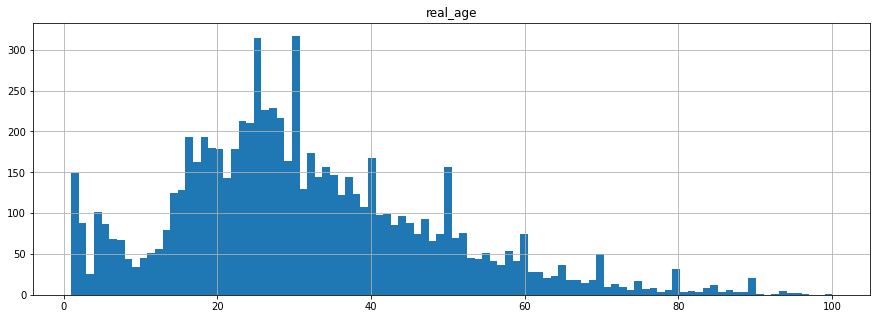

In [5]:
ax = labels.hist(figsize=(15, 5), bins=100)

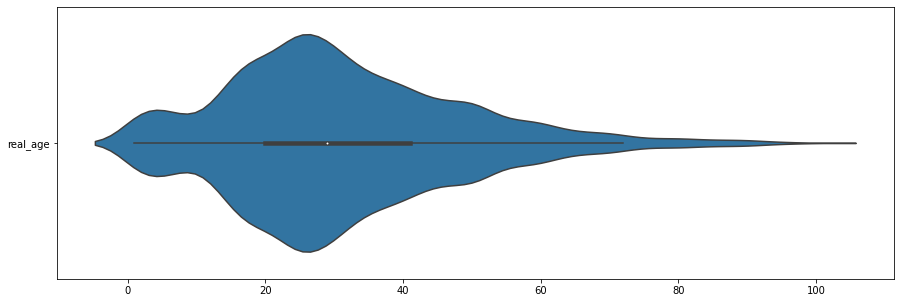

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.violinplot(data=labels, orient='h', ax=ax)
plt.show()

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=os.path.join(DATA_PATH, 'final_files'),
    x_col='file_name',
    y_col='real_age',
    batch_size=1,
    class_mode='raw',
)

Found 7591 validated image filenames.


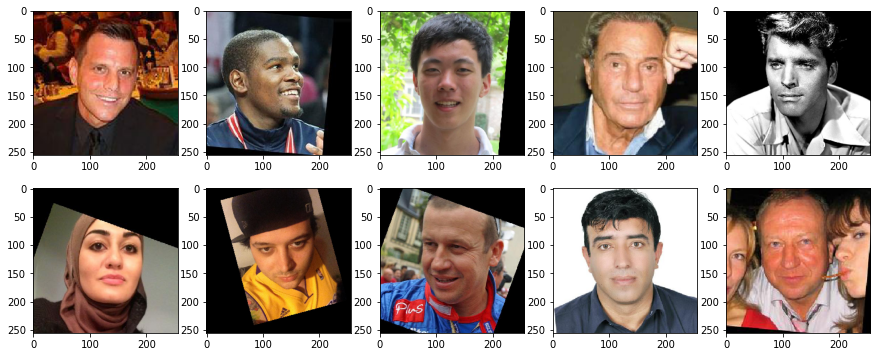

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    img, age = datagen_flow.next()
    axes[i].imshow(img[0])
plt.show()

- средний возраст 31 год
- медианный возраст 29 лет
- на фото присутствуют люди возрастом от 0 до 100 лет
- лица старше 75 встречаются редко
- есть фотографии, на которых искусственно центрированы лица. пропуски заполнены чёрным цветом
- люди на фото принадлежат людям разных возрастов, полов, рас, что здорово

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import os

import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


def load_train(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(
        validation_split=.25,
        rescale=1/255.,
        vertical_flip=True,
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training',
    )

    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(
        validation_split=.25,
        rescale=1/255.,
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation',
    )

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_absolute_error', optimizer=Adam(lr=.0001), metrics=['mae'])

    return model


def train_model(
        model,
        train_data,
        test_data,
        batch_size=None,
        epochs=10,
        steps_per_epoch=None,
        validation_steps=None,
):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model


```

```

2023-03-05 19:38:36.588808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-03-05 19:38:36.590603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-03-05 19:38:37.441232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-05 19:38:37.450929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-03-05 19:38:37.450992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-05 19:38:37.451023: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-05 19:38:37.452914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-03-05 19:38:37.453283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-03-05 19:38:37.455301: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-03-05 19:38:37.456441: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-03-05 19:38:37.456497: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-03-05 19:38:37.460173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-03-05 19:38:37.632185: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-05 19:38:37.638425: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-03-05 19:38:37.639016: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45f1fd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-05 19:38:37.639043: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-03-05 19:38:37.806897: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3c52130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 19:38:37.806937: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-05 19:38:37.809321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-03-05 19:38:37.809395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-05 19:38:37.809411: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-05 19:38:37.809454: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-03-05 19:38:37.809473: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-03-05 19:38:37.809492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-03-05 19:38:37.809510: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-03-05 19:38:37.809522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-03-05 19:38:37.813527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-03-05 19:38:37.813601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-05 19:38:38.257394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-03-05 19:38:38.257442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-03-05 19:38:38.257452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-03-05 19:38:38.261432: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-05 19:38:38.261489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-03-05 19:38:48.707704: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-05 19:38:49.055777: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 13.1372 - mae: 13.1380 - val_loss: 25.9850 - val_mae: 25.9978
Epoch 2/10
178/178 - 43s - loss: 8.0642 - mae: 8.0643 - val_loss: 22.8117 - val_mae: 22.7855
Epoch 3/10
178/178 - 44s - loss: 6.9020 - mae: 6.9021 - val_loss: 15.6600 - val_mae: 15.6320
Epoch 4/10
178/178 - 43s - loss: 6.1791 - mae: 6.1792 - val_loss: 9.0727 - val_mae: 9.0559
Epoch 5/10
178/178 - 43s - loss: 5.5977 - mae: 5.5981 - val_loss: 7.9662 - val_mae: 7.9705
Epoch 6/10
178/178 - 44s - loss: 5.2617 - mae: 5.2620 - val_loss: 7.1853 - val_mae: 7.2121
Epoch 7/10
178/178 - 43s - loss: 4.8459 - mae: 4.8459 - val_loss: 7.4239 - val_mae: 7.4339
Epoch 8/10
178/178 - 43s - loss: 4.4935 - mae: 4.4938 - val_loss: 7.3841 - val_mae: 7.3982
Epoch 9/10
178/178 - 40s - loss: 4.2241 - mae: 4.2242 - val_loss: 6.6840 - val_mae: 6.7212
Epoch 10/10
178/178 - 39s - loss: 4.0714 - mae: 4.0715 - val_loss: 6.6400 - val_mae: 6.6581
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 6.6400 - mae: 6.6581
Test MAE: 6.6581

```

## Анализ обученной модели

- Модель достигла MAE = 6.6581 на тестовой выборке

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы